# Scanpy analysis

This jupyter notebook describes the analysis of the single-cell data that was generated as part of running kallistobustools which is part of scflow.

The data was processed using the kallisto bustools pipeline (https://pachterlab.github.io/kallisto/about)and (https://github.com/Acribbs/scflow). The downstream analysis is shown below.

## Load the libraries

In [33]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import anndata
from sklearn.decomposition import TruncatedSVD

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
#from rpy2.robjects import r, pandas2ri

# pip install pyyaml
import yaml

with open("../../pipeline.yml", 'r') as stream:
    try:
        print(yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

{'genome_file': 'Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz', 'geneset': 'Homo_sapiens.GRCh38.99.gtf.gz', 'intron_bed': 'introns.bed.gz', 'cdna_fasta': 'cDNA.fa.gz', 'mixed_species': 0, 'genome2': None, 'genome_dir2': '/ifs/mirror/genomes/index/', 'geneset2': None, 'sc_dir': '/ifs/projects/adam/single-cell-test/', 'projectname': 'test', 'copyright': 'Cribbs Group, Botnar Research Centre (2019)', 'data': 0, 'kallisto': {'kmer': 31, 'threads': 5, 'bustools': 0, 'sctechnology': 'DropSeq', 'output_format': 'h5ad', 'workflow': 'standard', 'num_cells': 3000}, 'filtering': {'min_counts': 50, 'max_counts': 5000, 'percent_mito': 0.2, 'min_genes': 50}}


In [50]:
stream = yaml.safe_load(open("../../pipeline.yml", 'r'))

In [35]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
scanpy==1.4.5 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [36]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
#library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

# Import data


In [37]:
adata = anndata.read('bus/counts_unfiltered/adata.h5ad')
tsg = pd.read_csv("../../geneset.dir/t2g.txt", sep="\t", names=["Transcript","ensembl_id","gene_name", "gene_name_no", "chr", "start", "end", "strand"])
tsg = tsg[["ensembl_id", "gene_name"]]
tsg["genes"] = tsg[["gene_name"]]
tsg = tsg.drop_duplicates()
var = adata.var
merged = tsg.merge(var, left_on="ensembl_id", right_index=True)
merged
merged.set_index("gene_name_x", inplace=True)
adata.var = merged

/Users/adamcribbs/miniconda3/envs/scanpy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [38]:
adata.var_names

Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2', 'FAM138A',
       'OR4G4P', 'OR4G11P', 'OR4F5', 'AL627309.1',
       ...
       'AC004556.1', 'AC004556.4', 'AC004556.2', 'AC233755.2', 'AC233755.1',
       'AC240274.1', 'AC213203.2', 'AC213203.3', 'AC213203.4', 'AC213203.1'],
      dtype='object', name='gene_name_x', length=60676)

In [39]:
adata.var_names_make_unique()


## Test for library saturation

(1, 11220.18454301963)

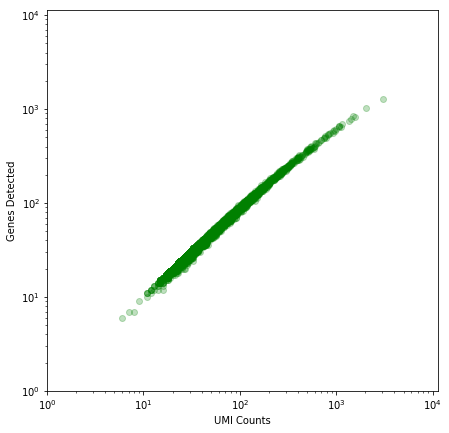

In [40]:
fig, ax = plt.subplots(figsize=(7, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)


(1, 10000)

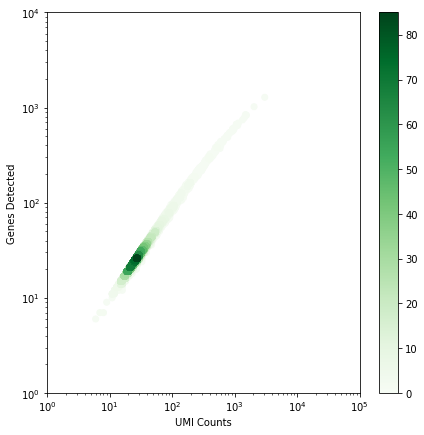

In [41]:
fig, ax = plt.subplots(figsize=(7,7))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]


s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

## Knee plot

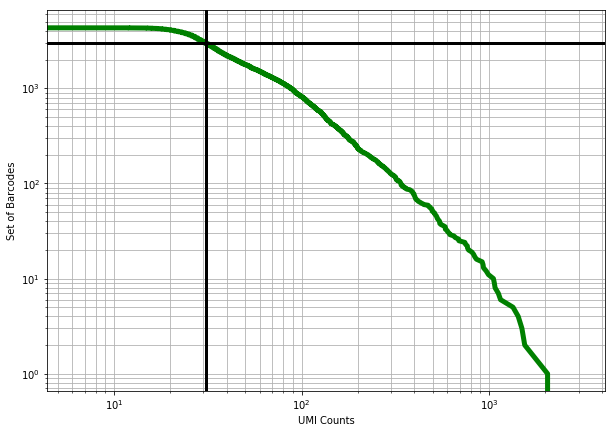

In [42]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  stream['kallisto']['num_cells']#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

## Perform SVD

(-7.535236793436029, 158.12169309226414, -21.7659886463626, 26.845397291992487)

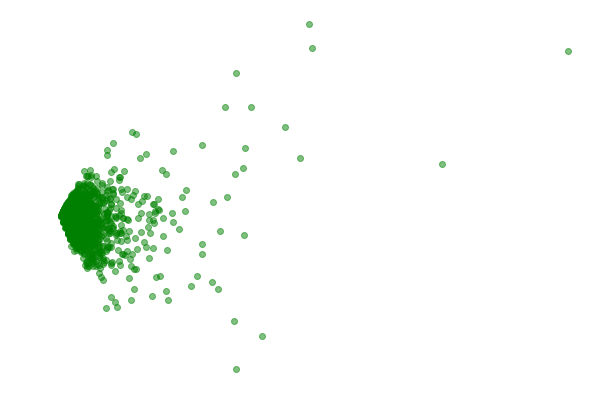

In [43]:

tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.axis('off')

# Quality control

/Users/adamcribbs/miniconda3/envs/scanpy/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/adamcribbs/miniconda3/envs/scanpy/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
... storing 'genes' as categorical


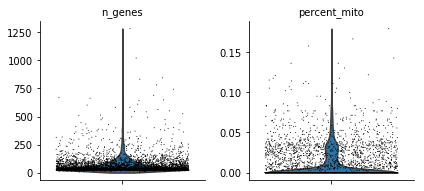

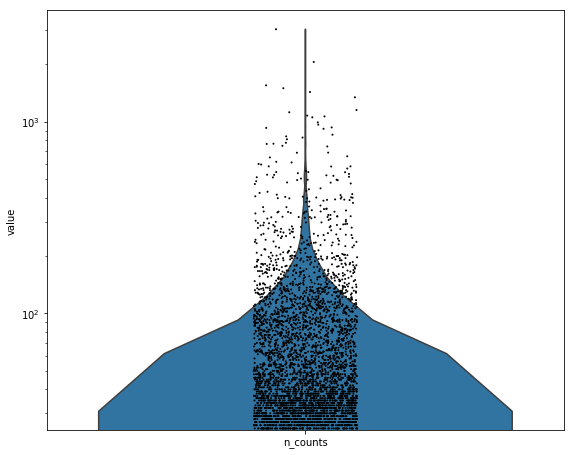

In [44]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mito_genes = adata.var.genes.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

t2= sc.pl.violin(adata, ['n_genes', "percent_mito"],
             jitter=0.4, multi_panel=True, save="variables.svg")

t1 = sc.pl.violin(adata, 'n_counts', size=2, log=True, cut=0)

## Data quality summary plots

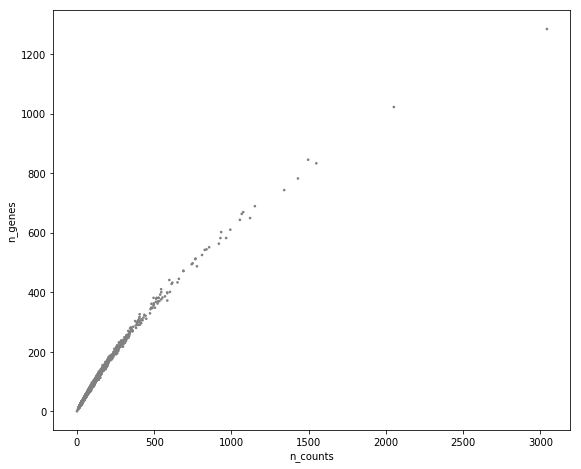

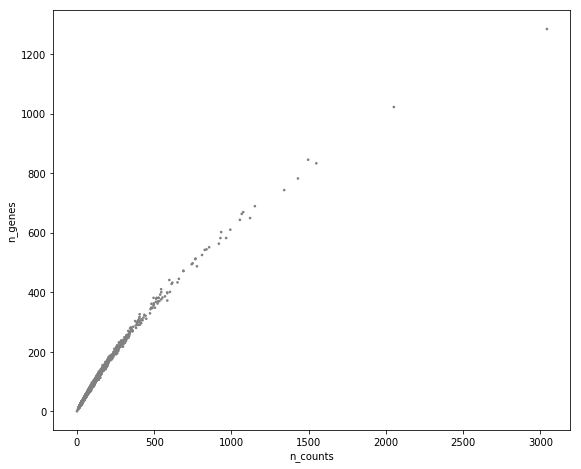

In [45]:
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes')

## Thresholding decision: counts


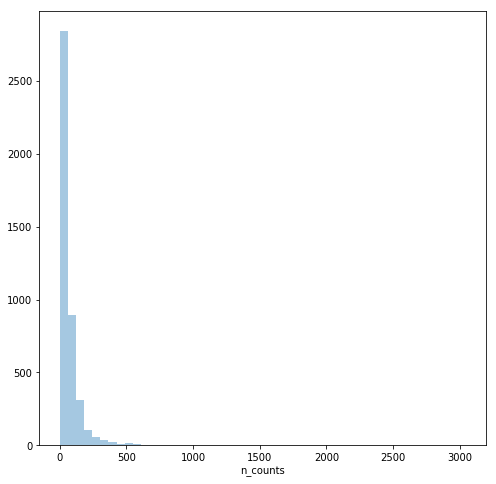

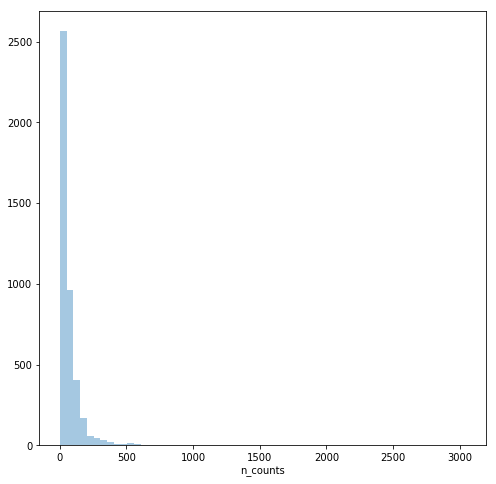

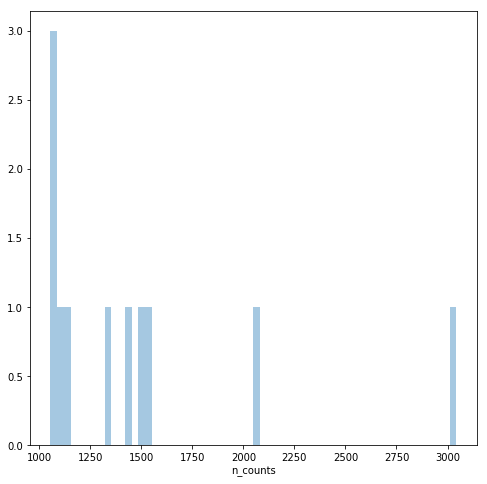

In [46]:
p3 = sb.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>1000], kde=False, bins=60)
plt.show()

## Thresholding decision: genes


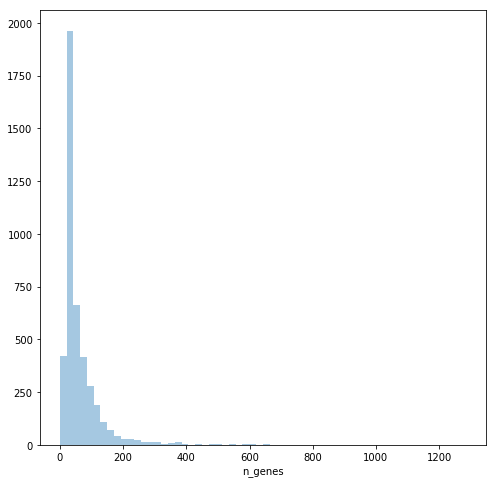

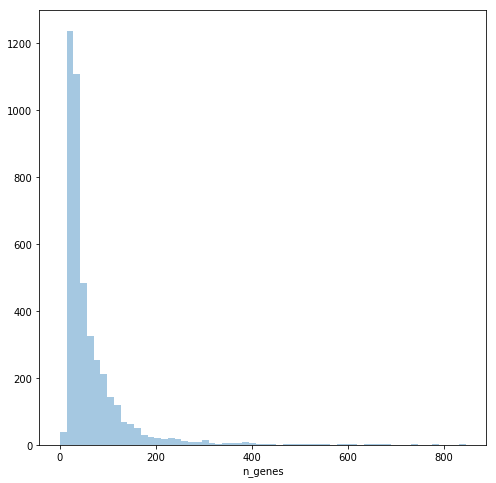

In [47]:
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

## Filter cells according to identified QC thresholds:


In [48]:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = stream['filtering']['min_counts'])
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = stream['filtering']['max_counts'])
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['percent_mito'] < stream['filtering']['percent_mito']]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = stream['filtering']['min_genes'])
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 4330
filtered out 2536 cells that have less than 50 counts
Number of cells after min count filter: 1794
Number of cells after max count filter: 1794
Number of cells after MT filter: 1794
filtered out 132 cells that have less than 50 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after gene filter: 1662


In [51]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=stream['filtering']['zero_genes'])
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 60676
filtered out 57973 genes that are detected in less than 10 cells
Number of genes after cell filter: 2703


# Normalisation

In [52]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 15
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 3 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:00)


In [53]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T
cell_names = adata.obs_names
gene_names = adata.var_names

In [54]:
%%R -i data_mat -i input_groups -i cell_names -i gene_names -o size_factors

size_factors = scran::computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

library(Seurat)
colnames(data_mat) <- cell_names
rownames(data_mat) <- gene_names
so <- CreateSeuratObject(counts = data_mat, project = "test")
so[["percent.mt"]] <- PercentageFeatureSet(so, pattern = "^MT-")
VlnPlot(so, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

saveRDS(so, file="seurat_output.rds")

In [55]:
#Delete adata_pp
del adata_pp

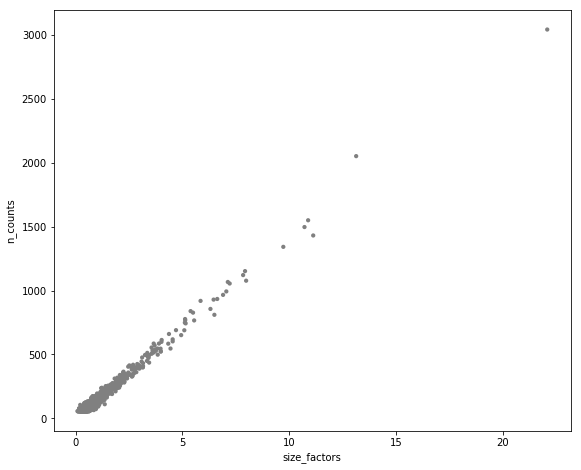

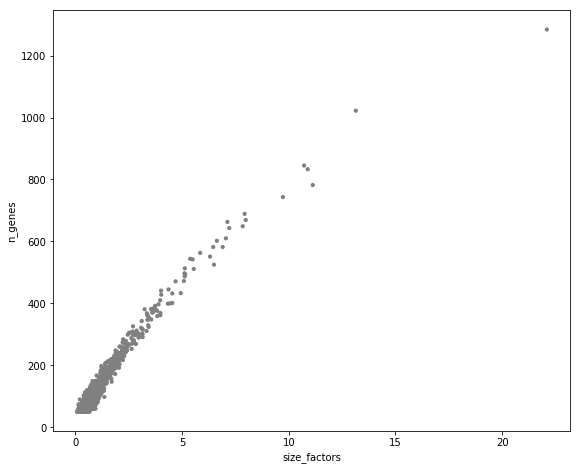

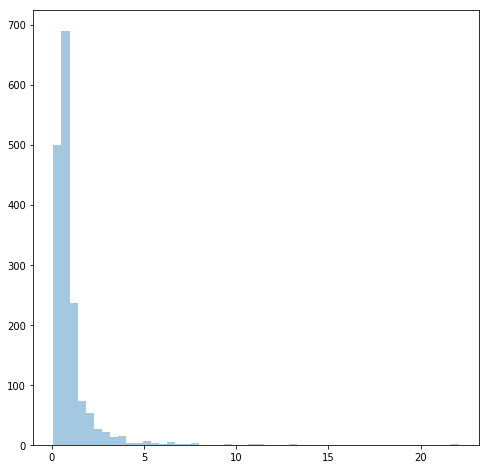

In [56]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [57]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [58]:
#Normalize adata 
#adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [84]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
#adata.raw = adata
#sc.pp.scale(adata)
#adata.var.index = adata.var["gene_name"]

# Highly variable genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


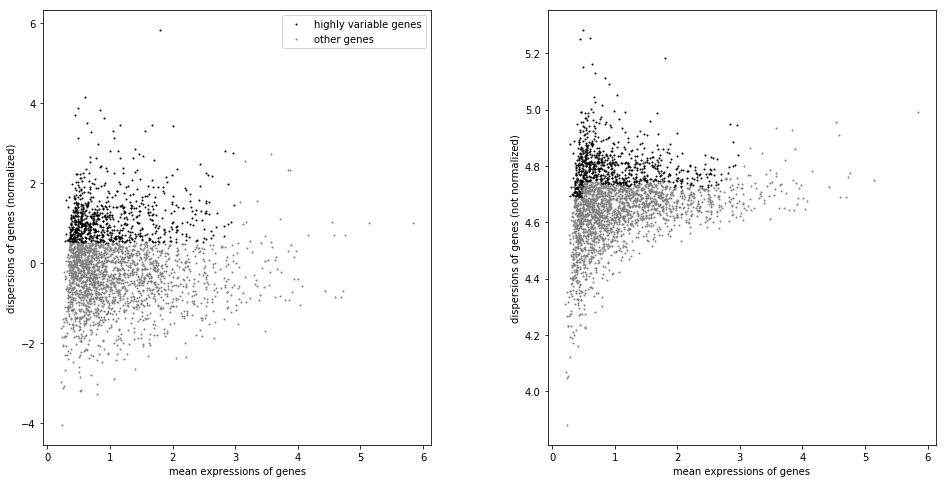

In [59]:
sc.pp.highly_variable_genes(adata, min_mean=0.125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save="highly_variable_genes.svg")

In [60]:
adata.X

<1662x2703 sparse matrix of type '<class 'numpy.float32'>'
	with 182398 stored elements in Compressed Sparse Row format>

# Visualisation

In [61]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=15, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 15
    on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.93133557 0.9160761  0.89536375 0.88858896 0.886414
     0.8795764  0.8665204  0.8611315  0.852021   0.84364635 0.8406268
     0.83022    0.8202955  0.817315  ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fr', graph_drawing coordinates (adata.obsm) (0:00:04)


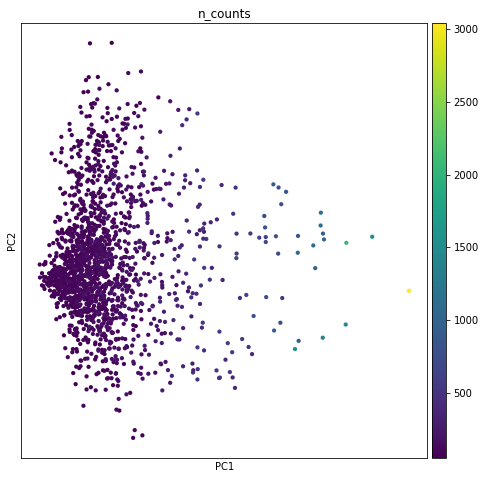

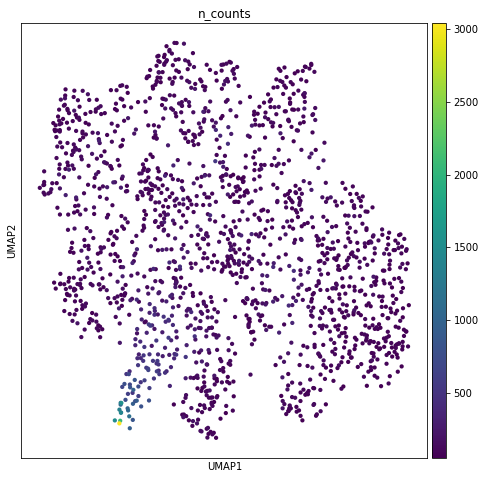

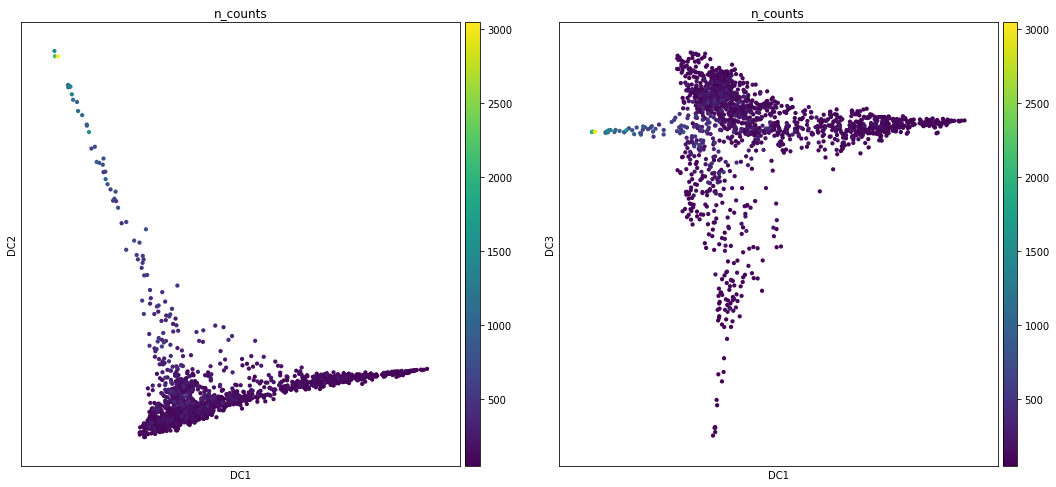

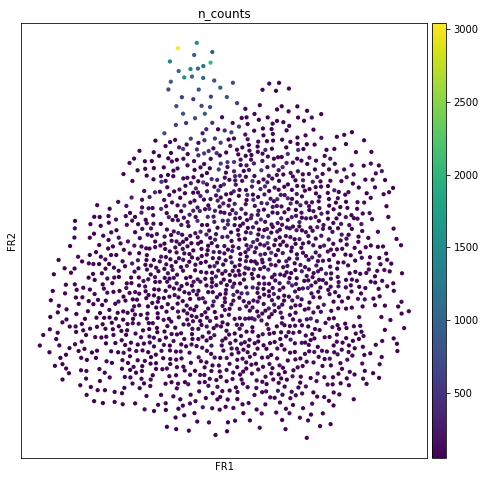

In [62]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts', save="umap.svg")
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'],  save="diffmap.svg")
sc.pl.draw_graph(adata, color='n_counts')

# Clustering

In [63]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_r1', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.5', the cluster labels (adata.obs, categorical) (0:00:00)


In [64]:
adata.obs['louvain_r0.5'].value_counts()

0    426
1    316
2    254
3    193
4    161
5    114
6    102
7     96
Name: louvain_r0.5, dtype: int64

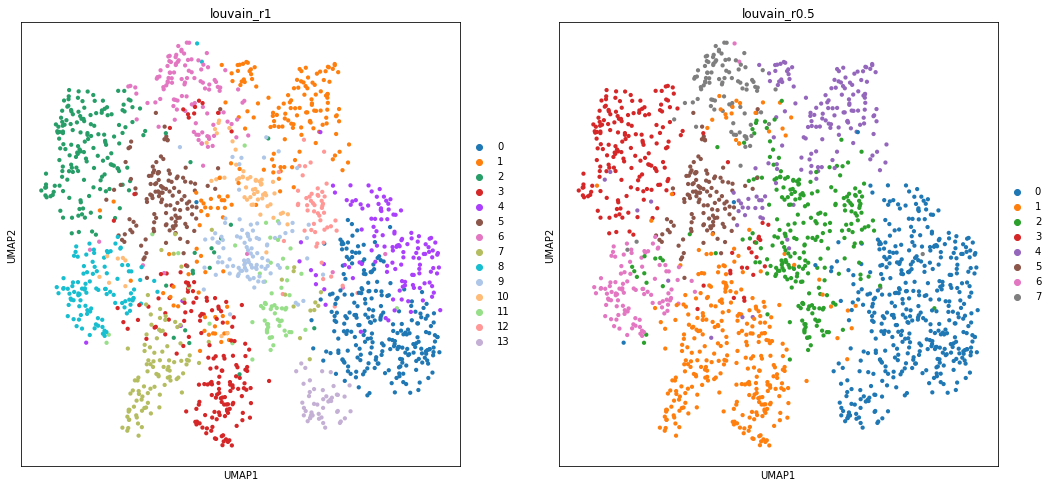

In [65]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], save="clustering.svg")


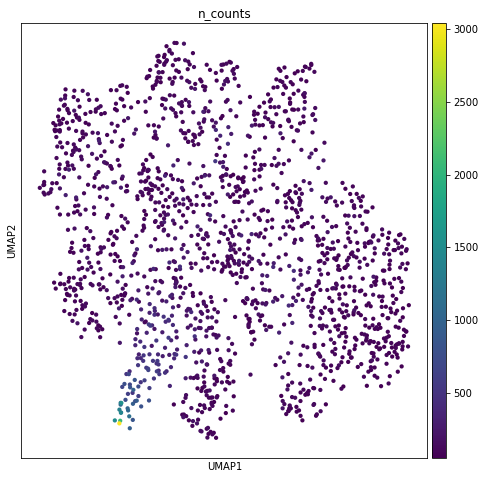

In [66]:
sc.pl.umap(adata, color=['n_counts'])

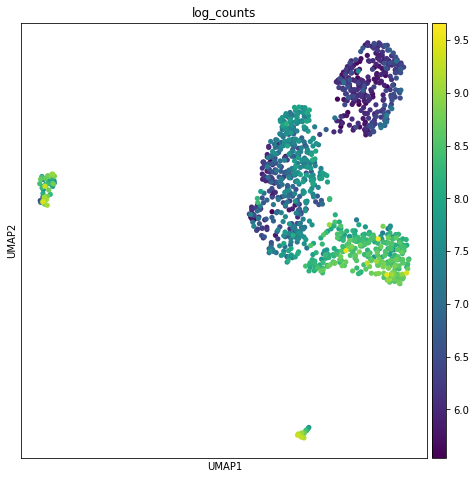

In [93]:
sc.pl.umap(adata, color=['log_counts'])

# Marker genes & cluster annotation

In [67]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata, groupby='louvain_r0.5', key_added='rank_genes_r0.5')

ranking genes
    finished: added to `.uns['rank_genes_r0.5']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


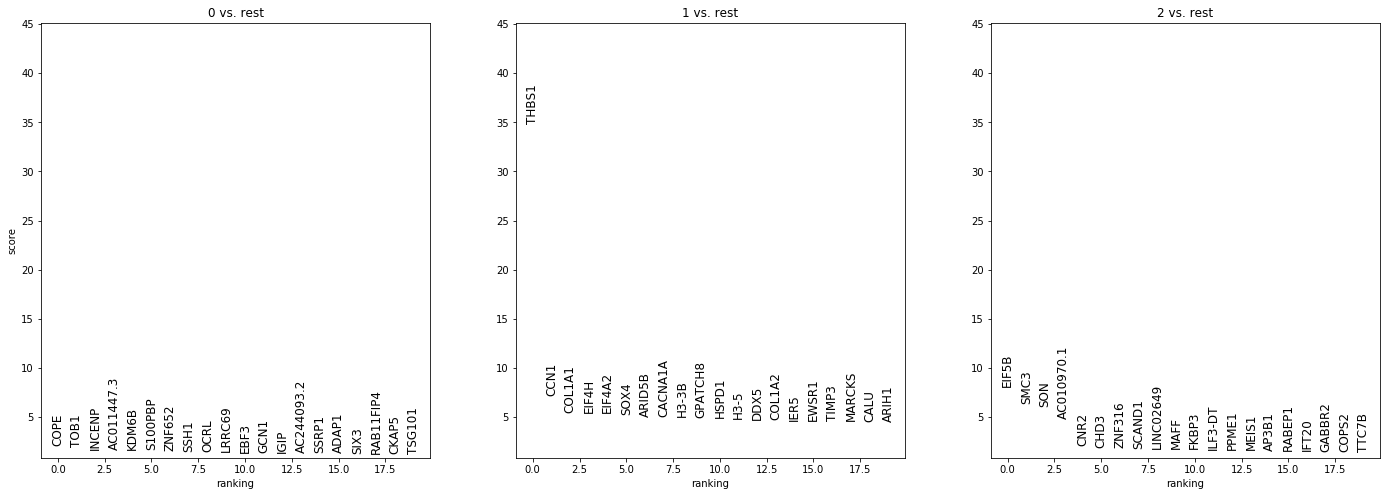

In [68]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', groups=['0','1','2'], fontsize=12,  use_raw=False)

# Write data to file

In [69]:
adata.write_h5ad('output.h5ad')
#adata.write_loom('output.loom', write_obsm_varm=True)
adata.write_csvs("output_info")

writing .csv files to output_info
